## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [28]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from tqdm import tqdm

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [3]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

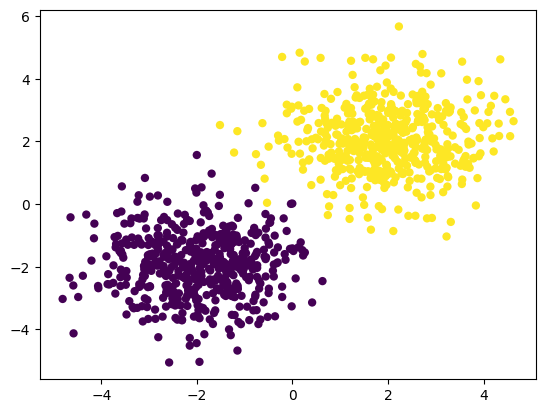

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

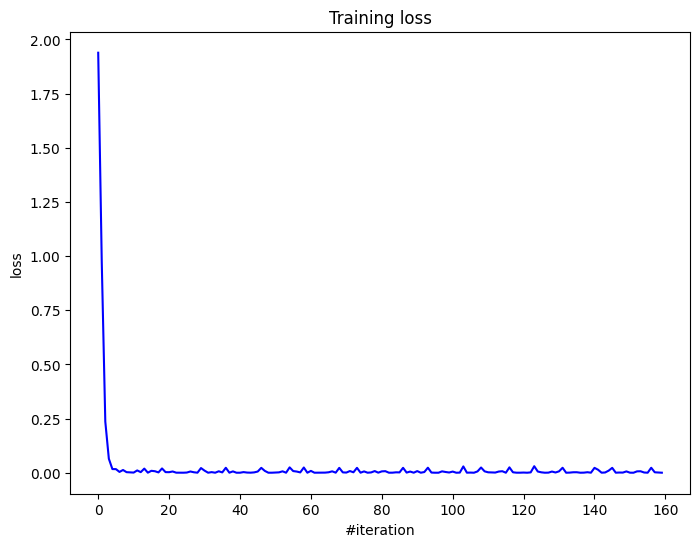

Current loss: 0.000061


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [9]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [10]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [12]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((50000, 28, 28),
 (50000,),
 (10000, 28, 28),
 (10000,),
 (10000, 28, 28),
 (10000,))

In [14]:
X_train_flat = X_train.reshape(-1, 28 * 28).astype(np.float32)
X_val_flat = X_val.reshape(-1, 28 * 28).astype(np.float32)
X_test_flat = X_test.reshape(-1, 28 * 28).astype(np.float32)

In [15]:
X_train_flat.shape, X_val_flat.shape, X_test_flat.shape

((50000, 784), (10000, 784), (10000, 784))

In [17]:
def to_one_hot(y, num_classes):
    y = y.astype(np.int64)
    one_hot = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    one_hot[np.arange(y.shape[0]), y] = 1.0
    return one_hot

In [18]:
Y_train = to_one_hot(y_train, 10)
Y_val = to_one_hot(y_val, 10)
Y_test = to_one_hot(y_test, 10)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [24]:
def build_net(activation_cls, use_bn=False, hidden_units=256):
    net = Sequential()
    net.add(Linear(28*28, hidden_units))
    if use_bn:
        net.add(BatchNormalization(alpha=0.1))
        net.add(ChannelwiseScaling(hidden_units))
    net.add(activation_cls())
    net.add(Linear(hidden_units, 10))
    net.add(LogSoftMax())
    return net

In [25]:
def compute_loss_and_accuracy(net, X, Y, criterion, batch_size=512):
    losses = []
    correct = 0
    total = 0
    
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        preds = net.forward(x_batch)
        loss = criterion.forward(preds, y_batch)
        losses.append(loss)
        
        y_true = np.argmax(y_batch, axis=1)
        y_pred = np.argmax(preds, axis=1)
        correct += np.sum(y_pred == y_true)
        total   += y_true.shape[0]
    
    return np.mean(losses), correct / total

In [41]:
def train_model(net, optimizer_name='momentum', n_epoch=10, batch_size=128, 
                lr=1e-2, momentum=0.9, beta1=0.9, beta2=0.999, eps=1e-8):
    
    criterion = ClassNLLCriterion()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    if optimizer_name == 'momentum':
        optimizer = sgd_momentum
        optimizer_config = {'learning_rate': lr, 'momentum': momentum}
    elif optimizer_name == 'adam':
        optimizer = adam_optimizer
        optimizer_config = {'learning_rate': lr,
                            'beta1': beta1,
                            'beta2': beta2,
                            'epsilon': eps}
    else:
        raise ValueError("Unknown optimizer")

    optimizer_state = {}
    
    for epoch in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train_flat, Y_train), batch_size):
            net.zeroGradParameters()
            
            preds = net.forward(x_batch)
            loss = criterion.forward(preds, y_batch)
            
            dp = criterion.backward(preds, y_batch)
            net.backward(x_batch, dp)
            
            optimizer(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)
        
        train_loss, train_acc = compute_loss_and_accuracy(net, X_train_flat, Y_train, criterion)
        val_loss, val_acc = compute_loss_and_accuracy(net, X_val_flat, Y_val, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{n_epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")
    
    return {'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'net': net}

In [42]:
activations = [ReLU, ELU, LeakyReLU, SoftPlus]
results = {}

for act in activations:
    print("Activation:", act.__name__)
    net = build_net(act, use_bn=False)
    res = train_model(net, optimizer_name='adam', n_epoch=10, lr=1e-3)
    results[act.__name__] = res
    print()

Activation: ReLU
Epoch 1/10: train_loss=0.2184, val_loss=0.2119, train_acc=0.938, val_acc=0.942
Epoch 2/10: train_loss=0.1325, val_loss=0.1400, train_acc=0.963, val_acc=0.959
Epoch 3/10: train_loss=0.0934, val_loss=0.1128, train_acc=0.974, val_acc=0.969
Epoch 4/10: train_loss=0.0732, val_loss=0.0971, train_acc=0.979, val_acc=0.971
Epoch 5/10: train_loss=0.0594, val_loss=0.0920, train_acc=0.984, val_acc=0.972
Epoch 6/10: train_loss=0.0449, val_loss=0.0800, train_acc=0.988, val_acc=0.975
Epoch 7/10: train_loss=0.0347, val_loss=0.0807, train_acc=0.990, val_acc=0.977
Epoch 8/10: train_loss=0.0291, val_loss=0.0756, train_acc=0.993, val_acc=0.979
Epoch 9/10: train_loss=0.0220, val_loss=0.0749, train_acc=0.995, val_acc=0.978
Epoch 10/10: train_loss=0.0205, val_loss=0.0727, train_acc=0.995, val_acc=0.978

Activation: ELU
Epoch 1/10: train_loss=0.2559, val_loss=0.2450, train_acc=0.926, val_acc=0.930
Epoch 2/10: train_loss=0.1760, val_loss=0.1782, train_acc=0.949, val_acc=0.950
Epoch 3/10: train

In [43]:
print("ReLU without BN")
net_relu = build_net(ReLU, use_bn=False)
res_relu = train_model(net_relu, optimizer_name='adam', n_epoch=10, lr=1e-3)

ReLU without BN
Epoch 1/10: train_loss=0.2143, val_loss=0.2069, train_acc=0.938, val_acc=0.941
Epoch 2/10: train_loss=0.1350, val_loss=0.1422, train_acc=0.961, val_acc=0.961
Epoch 3/10: train_loss=0.0971, val_loss=0.1140, train_acc=0.973, val_acc=0.968
Epoch 4/10: train_loss=0.0741, val_loss=0.0988, train_acc=0.980, val_acc=0.972
Epoch 5/10: train_loss=0.0597, val_loss=0.0917, train_acc=0.983, val_acc=0.973
Epoch 6/10: train_loss=0.0457, val_loss=0.0855, train_acc=0.988, val_acc=0.974
Epoch 7/10: train_loss=0.0374, val_loss=0.0821, train_acc=0.991, val_acc=0.976
Epoch 8/10: train_loss=0.0272, val_loss=0.0764, train_acc=0.993, val_acc=0.978
Epoch 9/10: train_loss=0.0237, val_loss=0.0796, train_acc=0.994, val_acc=0.976
Epoch 10/10: train_loss=0.0201, val_loss=0.0793, train_acc=0.996, val_acc=0.978


In [44]:
print("ReLU with BN")
net_relu_bn = build_net(ReLU, use_bn=True)
res_relu_bn = train_model(net_relu_bn, optimizer_name='adam', n_epoch=10, lr=1e-3)

ReLU with BN
Epoch 1/10: train_loss=0.1291, val_loss=0.1357, train_acc=0.966, val_acc=0.962
Epoch 2/10: train_loss=0.0757, val_loss=0.1004, train_acc=0.981, val_acc=0.972
Epoch 3/10: train_loss=0.0521, val_loss=0.0904, train_acc=0.987, val_acc=0.974
Epoch 4/10: train_loss=0.0383, val_loss=0.0832, train_acc=0.991, val_acc=0.975
Epoch 5/10: train_loss=0.0280, val_loss=0.0813, train_acc=0.993, val_acc=0.976
Epoch 6/10: train_loss=0.0216, val_loss=0.0770, train_acc=0.996, val_acc=0.976
Epoch 7/10: train_loss=0.0166, val_loss=0.0774, train_acc=0.997, val_acc=0.977
Epoch 8/10: train_loss=0.0168, val_loss=0.0790, train_acc=0.996, val_acc=0.977
Epoch 9/10: train_loss=0.0118, val_loss=0.0798, train_acc=0.998, val_acc=0.977
Epoch 10/10: train_loss=0.0090, val_loss=0.0744, train_acc=0.999, val_acc=0.978


In [55]:
print("ReLU + BN, SGD with momentum")
net_sgd = build_net(ReLU, use_bn=True)
res_sgd = train_model(net_sgd, optimizer_name='momentum', n_epoch=10, lr=1e-2, momentum=0.9)

ReLU + BN, SGD with momentum
Epoch 1/10: train_loss=0.1674, val_loss=0.1660, train_acc=0.954, val_acc=0.956
Epoch 2/10: train_loss=0.1111, val_loss=0.1228, train_acc=0.971, val_acc=0.967
Epoch 3/10: train_loss=0.0830, val_loss=0.1020, train_acc=0.980, val_acc=0.972
Epoch 4/10: train_loss=0.0670, val_loss=0.0940, train_acc=0.985, val_acc=0.974
Epoch 5/10: train_loss=0.0538, val_loss=0.0887, train_acc=0.988, val_acc=0.975
Epoch 6/10: train_loss=0.0443, val_loss=0.0819, train_acc=0.991, val_acc=0.977
Epoch 7/10: train_loss=0.0363, val_loss=0.0796, train_acc=0.993, val_acc=0.978
Epoch 8/10: train_loss=0.0312, val_loss=0.0783, train_acc=0.995, val_acc=0.978
Epoch 9/10: train_loss=0.0262, val_loss=0.0752, train_acc=0.996, val_acc=0.977
Epoch 10/10: train_loss=0.0231, val_loss=0.0750, train_acc=0.997, val_acc=0.979


In [46]:
print("ReLU + BN, Adam")
net_adam = build_net(ReLU, use_bn=True)
res_adam = train_model(net_adam, optimizer_name='adam', n_epoch=10, lr=1e-3)

ReLU + BN, Adam
Epoch 1/10: train_loss=0.1282, val_loss=0.1346, train_acc=0.967, val_acc=0.963
Epoch 2/10: train_loss=0.0754, val_loss=0.1010, train_acc=0.981, val_acc=0.970
Epoch 3/10: train_loss=0.0525, val_loss=0.0879, train_acc=0.987, val_acc=0.975
Epoch 4/10: train_loss=0.0386, val_loss=0.0799, train_acc=0.990, val_acc=0.976
Epoch 5/10: train_loss=0.0269, val_loss=0.0770, train_acc=0.995, val_acc=0.976
Epoch 6/10: train_loss=0.0222, val_loss=0.0757, train_acc=0.996, val_acc=0.977
Epoch 7/10: train_loss=0.0194, val_loss=0.0764, train_acc=0.996, val_acc=0.978
Epoch 8/10: train_loss=0.0152, val_loss=0.0759, train_acc=0.997, val_acc=0.978
Epoch 9/10: train_loss=0.0122, val_loss=0.0766, train_acc=0.998, val_acc=0.978
Epoch 10/10: train_loss=0.0112, val_loss=0.0807, train_acc=0.998, val_acc=0.977


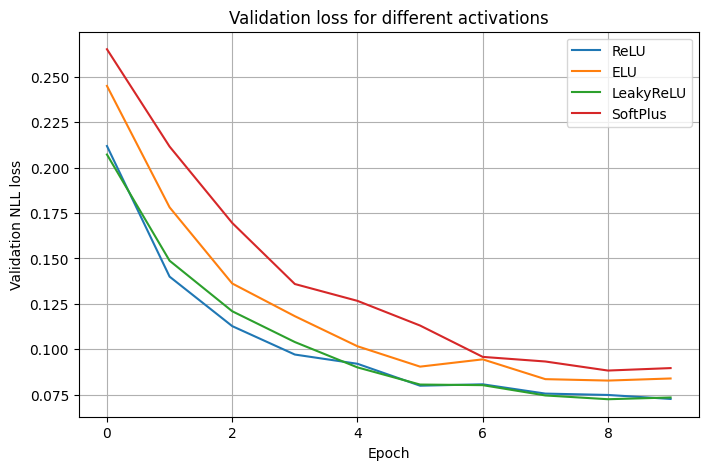

In [47]:
plt.figure(figsize=(8, 5))
for act_name, res in results.items():
    plt.plot(res['val_losses'], label=act_name)
    
plt.xlabel("Epoch")
plt.ylabel("Validation NLL loss")
plt.title("Validation loss for different activations")
plt.legend()
plt.grid()
plt.show()

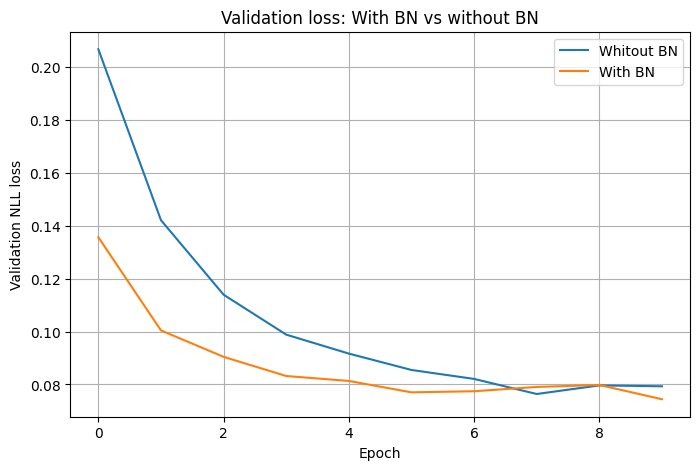

In [51]:
plt.figure(figsize=(8,5))
plt.plot(res_relu['val_losses'], label="Whitout BN")
plt.plot(res_relu_bn['val_losses'], label="With BN")
plt.xlabel("Epoch")
plt.ylabel("Validation NLL loss")
plt.title("Validation loss: With BN vs without BN")
plt.legend()
plt.grid()
plt.show()

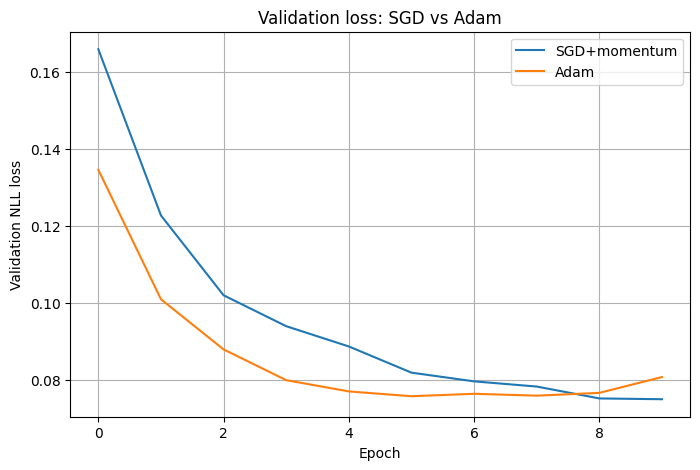

In [56]:
plt.figure(figsize=(8,5))
plt.plot(res_sgd['val_losses'], label="SGD+momentum")
plt.plot(res_adam['val_losses'], label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Validation NLL loss")
plt.title("Validation loss: SGD vs Adam")
plt.legend()
plt.grid()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Выводы:
- Из активационных функций лучшие и почти одинаковые результаты показали ReLU и LeakyReLU.
- Как и предполагалось BatchNormalization ускоряет обучение, что видно на графике выше.
- При Adam модель обучается быстрее, но потом переобучается, а при SGD+momentum модель обучается медленнее, но получаем результат получше.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [77]:
class MyBestNet(Sequential):
    def __init__(self):
        super().__init__()
        self.add(Linear(28*28, 512))
        self.add(BatchNormalization(alpha=0.1))
        self.add(ChannelwiseScaling(512))
        self.add(ReLU())
        self.add(Dropout(p=0.5))
        
        self.add(Linear(512, 256))
        self.add(BatchNormalization(alpha=0.1))
        self.add(ChannelwiseScaling(256))
        self.add(ReLU())
        self.add(Dropout(p=0.5))
        
        self.add(Linear(256, 10))
        self.add(LogSoftMax())

In [78]:
best_net = MyBestNet()
best_res = train_model(best_net, optimizer_name='adam', n_epoch=15, lr=1e-3)

Epoch 1/15: train_loss=0.1912, val_loss=0.1884, train_acc=0.942, val_acc=0.945
Epoch 2/15: train_loss=0.1360, val_loss=0.1473, train_acc=0.958, val_acc=0.956
Epoch 3/15: train_loss=0.1221, val_loss=0.1337, train_acc=0.962, val_acc=0.959
Epoch 4/15: train_loss=0.0975, val_loss=0.1273, train_acc=0.969, val_acc=0.963
Epoch 5/15: train_loss=0.0859, val_loss=0.1212, train_acc=0.973, val_acc=0.966
Epoch 6/15: train_loss=0.0814, val_loss=0.1242, train_acc=0.974, val_acc=0.965
Epoch 7/15: train_loss=0.0725, val_loss=0.1215, train_acc=0.977, val_acc=0.965
Epoch 8/15: train_loss=0.0661, val_loss=0.1049, train_acc=0.979, val_acc=0.969
Epoch 9/15: train_loss=0.0619, val_loss=0.1058, train_acc=0.979, val_acc=0.971
Epoch 10/15: train_loss=0.0570, val_loss=0.1126, train_acc=0.982, val_acc=0.969
Epoch 11/15: train_loss=0.0553, val_loss=0.1011, train_acc=0.983, val_acc=0.970
Epoch 12/15: train_loss=0.0500, val_loss=0.1033, train_acc=0.984, val_acc=0.970
Epoch 13/15: train_loss=0.0456, val_loss=0.1005, 

Print here your accuracy on test set. It should be around 90%.

In [82]:
best_net.evaluate()
log_probs_test = best_net.forward(X_test_flat)
y_pred_test = np.argmax(log_probs_test, axis=1)  

In [86]:
criterion = ClassNLLCriterion()
test_loss, test_acc = compute_loss_and_accuracy(best_net, X_test_flat, Y_test, criterion)
print(f"Test loss = {test_loss:.4f}, test accuracy = {test_acc:.4f}")

Test loss = 0.0536, test accuracy = 0.9845


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [59]:
X_train_t = torch.from_numpy(X_train_flat).float().to(device)
y_train_t = torch.from_numpy(y_train.astype(np.int64)).to(device)

X_val_t   = torch.from_numpy(X_val_flat).float().to(device)
y_val_t   = torch.from_numpy(y_val.astype(np.int64)).to(device)

X_test_t  = torch.from_numpy(X_test_flat).float().to(device)
y_test_t  = torch.from_numpy(y_test.astype(np.int64)).to(device)

In [62]:
class TorchBestNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(28 * 28, 512),
                                 nn.BatchNorm1d(512),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(512, 256),
                                 nn.BatchNorm1d(256),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(256, 10)
                                )
    def forward(self, x):
        return self.net(x)

In [67]:
model = TorchBestNet().to(device)
criterion_t = nn.CrossEntropyLoss()
optimizer_t = optim.Adam(model.parameters(), lr=1e-3)

In [68]:
batch_size = 128
n_epoch = 15

In [69]:
for epoch in range(n_epoch):
    model.train()
    perm = torch.randperm(X_train_t.size(0))
    epoch_loss = 0.
    for i in range(0, X_train_t.size(0), batch_size):
        idx = perm[i:i+batch_size]
        xb = X_train_t[idx]
        yb = y_train_t[idx]
        
        optimizer_t.zero_grad()
        logits = model(xb)
        loss = criterion_t(logits, yb)
        loss.backward()
        optimizer_t.step()
        
        epoch_loss += loss.item() * xb.size(0)
    
    epoch_loss /= X_train_t.size(0)
    
    model.eval()
    with torch.no_grad():
        train_logits = model(X_train_t)
        train_pred = train_logits.argmax(dim=1)
        train_acc = (train_pred == y_train_t).float().mean().item()
        
        val_logits = model(X_val_t)
        val_pred = val_logits.argmax(dim=1)
        val_acc = (val_pred == y_val_t).float().mean().item()
    
    print(f"Epoch {epoch+1}: train_loss={epoch_loss:.4f}, train_acc={train_acc:.3f} val_acc={val_acc:.3f}")

Epoch 1: train_loss=0.3483, train_acc=0.965 val_acc=0.963
Epoch 2: train_loss=0.1794, train_acc=0.976 val_acc=0.971
Epoch 3: train_loss=0.1441, train_acc=0.982 val_acc=0.974
Epoch 4: train_loss=0.1223, train_acc=0.985 val_acc=0.977
Epoch 5: train_loss=0.1109, train_acc=0.988 val_acc=0.978
Epoch 6: train_loss=0.1003, train_acc=0.989 val_acc=0.979
Epoch 7: train_loss=0.0909, train_acc=0.991 val_acc=0.980
Epoch 8: train_loss=0.0832, train_acc=0.993 val_acc=0.980
Epoch 9: train_loss=0.0807, train_acc=0.993 val_acc=0.980
Epoch 10: train_loss=0.0730, train_acc=0.994 val_acc=0.980
Epoch 11: train_loss=0.0660, train_acc=0.995 val_acc=0.983
Epoch 12: train_loss=0.0655, train_acc=0.995 val_acc=0.982
Epoch 13: train_loss=0.0617, train_acc=0.996 val_acc=0.983
Epoch 14: train_loss=0.0592, train_acc=0.996 val_acc=0.982
Epoch 15: train_loss=0.0584, train_acc=0.997 val_acc=0.984


In [74]:
model.eval()
with torch.no_grad():
    test_logits = model(X_test_t)
    test_pred = test_logits.argmax(dim=1)
    test_acc = (test_pred == y_test_t).float().mean().item()
print(f"Test accuracy = {test_acc:.3f}")

Test accuracy = 0.984
